In [210]:
## setup
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np
from statsmodels.iolib.summary2 import summary_col
from statsmodels.graphics.regressionplots import plot_partregress
from pathlib import Path

In [212]:
## upload cleaned data
# path setup (choose base)
base_folder = Path().resolve()

data_folder = base_folder / "data"

cleaned_folder = data_folder / "clean_data"

# load data
milk_df_path = cleaned_folder / "milk_df_clean.xlsx"
milk_df = pd.read_excel(milk_df_path)

milk_df_cpi_path = cleaned_folder / "milk_df_inflation_adjusted.xlsx"
milk_df_inflation = pd.read_excel(milk_df_cpi_path)

milk_df_inflation

,Year,State,Organic,milk_sold,gross_value,feed_costs,vet_costs,bedding_litter_costs,marketing_costs,service_costs,...,bedding_litter_costs_real,marketing_costs_real,service_costs_real,utility_costs_real,repair_costs_real,total_operating_costs_real,overhead_real,total_costs_real,cpi_index_y,cpi_index
0,2005,Minnesota,1,20.88,23.17,10.11,0.54,0.38,0.43,0.49,...,0.380000,0.430000,0.490000,0.890000,1.070000,14.300000,16.310000,30.610000,1.000000,1.000000
1,2005,New York,1,24.03,26.87,13.08,0.35,0.37,0.24,0.10,...,0.370000,0.240000,0.100000,1.120000,0.940000,16.630000,21.370000,38.000000,1.000000,1.000000
2,2005,Pennsylvania,1,24.23,26.85,13.23,0.68,0.46,0.31,0.23,...,0.460000,0.310000,0.230000,0.730000,0.940000,17.100000,14.610000,31.710000,1.000000,1.000000
3,2005,Vermont,1,24.23,26.87,13.61,0.81,0.52,0.24,0.22,...,0.520000,0.240000,0.220000,0.980000,0.870000,17.620000,18.880000,36.500000,1.000000,1.000000
4,2005,Wisconsin,1,21.19,23.63,13.47,0.60,0.39,0.22,0.33,...,0.390000,0.220000,0.330000,0.840000,0.850000,17.110000,14.950000,32.070000,1.000000,1.000000
5,2010,Minnesota,1,25.17,27.81,14.01,0.49,0.47,0.25,0.60,...,0.430224,0.228843,0.549222,1.098445,0.594991,16.375979,20.128998,36.504976,1.092454,1.092454
6,2010,New York,1,24.29,27.22,11.58,0.62,0.52,0.39,0.68,...,0.475993,0.356995,0.622452,1.135059,1.089291,15.002923,16.568206,31.571129,1.092454,1.092454
7,2010,Pennsylvania,1,28.37,30.92,14.05,0.51,0.44,0.23,0.41,...,0.402763,0.210535,0.375302,1.318134,1.418824,17.218120,18.783403,36.001523,1.092454,1.092454
8,2010,Vermont,1,25.97,28.61,15.88,0.57,0.50,0.23,0.45,...,0.457685,0.210535,0.411917,1.208289,1.794126,19.268550,20.550068,39.818618,1.092454,1.092454
9,2010,Wisconsin,1,27.90,30.89,14.75,0.80,0.58,0.19,0.93,...,0.530915,0.173920,0.851295,0.997754,1.189982,18.170105,19.360087,37.530191,1.092454,1.092454


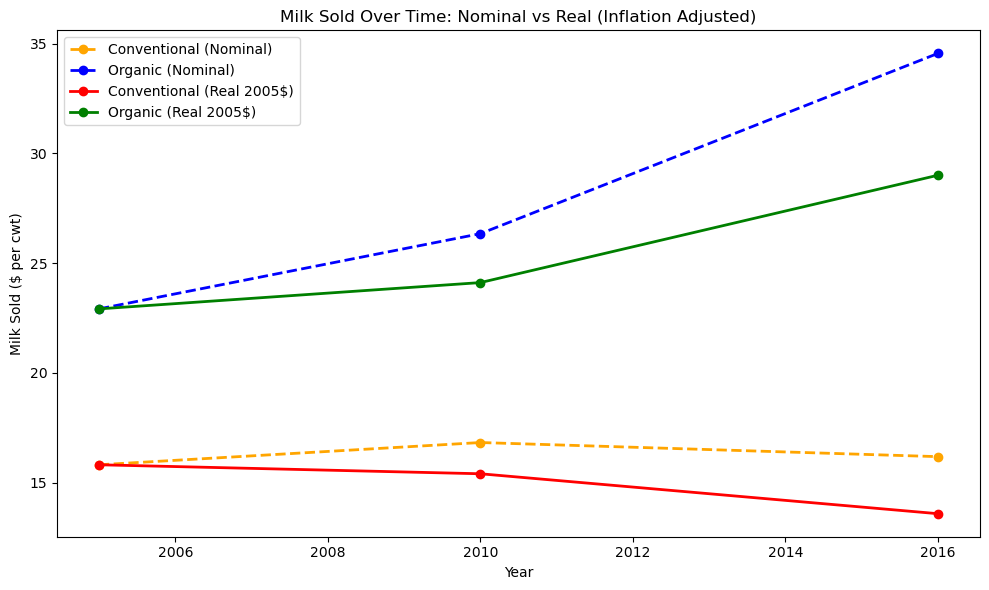

In [348]:
### data exploration 

## explore milk_sold
# control for inflation
milk_df_inflation["milk_sold_real"] = milk_df_inflation["milk_sold"] / milk_df_inflation["cpi_index"]

# get average milk_sold by year and organic/nonorganic
trend_nominal = (milk_df_inflation.groupby(["Year", "Organic"])["milk_sold"]
                 .mean().reset_index())

trend_real = (milk_df_inflation.groupby(["Year", "Organic"])["milk_sold_real"]
              .mean().reset_index())

# names and colors for plot (nominal)
name_map = {0: "Conventional", 1: "Organic"}
nominal_color_map = {0: "orange", 1: "blue"}

# names and colors for plot (real)
real_color_map = {0: "red", 1: "green"}

# create plot
plt.figure(figsize = (10, 6))

# loop for plot (nominal)
for label, grp in trend_nominal.groupby("Organic"):
    plt.plot(grp["Year"], grp["milk_sold"],
             marker = "o", linestyle = "--", linewidth = 2, 
             color = nominal_color_map[label], label = f"{name_map[label]} (Nominal)")

# loop for plot (real)
for label, grp in trend_real.groupby("Organic"):
    plt.plot(grp["Year"], grp["milk_sold_real"],
             marker = "o", linewidth = 2,
             color = real_color_map[label], label = f"{name_map[label]} (Real 2005$)")

# add plot details
plt.xlabel("Year")
plt.ylabel("Milk Sold ($ per cwt)")
plt.title("Milk Sold Over Time: Nominal vs Real (Inflation Adjusted)")
plt.legend()
plt.tight_layout()


# export figure
figures_folder = base_folder / "figures"

figure1_path = figures_folder / "milk_sold_over_time.png"

plt.savefig(figure1_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()

In [216]:
## analysis (profit model)

# make sure oragnic column is an integer
milk_df_inflation["organic_bin"] = milk_df_inflation["Organic"].astype(int) 


# compute profit (estimate)
milk_df_inflation["profit"] = milk_df_inflation["gross_value"] - milk_df_inflation["total_costs"]

# create real profit value
milk_df_inflation["profit_real"] = milk_df_inflation["profit"] / milk_df_inflation["cpi_index"]

# OLS regression profit model
profit_model = smf.ols(formula = "profit_real ~ organic_bin",
    data = milk_df_inflation).fit()

# return model
profit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            profit_real   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     14.89
Date:                Sat, 13 Dec 2025   Prob (F-statistic):           0.000613
Time:                        13:35:20   Log-Likelihood:                -80.141
No. Observations:                  30   AIC:                             164.3
Df Residuals:                      28   BIC:                             167.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.5934      0.935     -1.704      0.099      -3.509       0.322
organic_bin    -5.1029      1.322     -3.859      0.001      -7.812      -2.394
==============================================================================
Omnibus:                        0.861   Durbin-Watson:                   1.793
Prob(Omnibus):                  0.650   Jarque-Bera (JB):                0.203
Skew:                           0.157   Prob(JB):                        0.904
Kurtosis:                       3.253   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [268]:
## create table of profit model for paper

# put model selected results into a dataframe
results1_table = pd.DataFrame({"coef": profit_model.params,
                               "std_err": profit_model.bse,
                               "t_value": profit_model.tvalues,
                               "p_value": profit_model.pvalues,
                               "lower_CI": profit_model.conf_int()[0],
                               "upper_CI": profit_model.conf_int()[1]})

# view the table
results1_table

# create path to folder
results_folder = base_folder / "results"

output_path = results_folder / "profit_model_results.xlsx"

results1_table.to_excel(output_path, index = True)

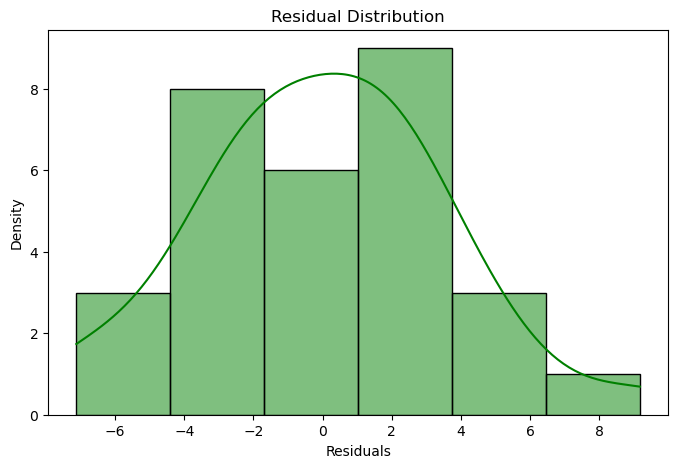

In [342]:
## visual for profit model

# create residuals variable
residuals = profit_model.resid

# plot residuals on a histogram with KDE
plt.figure(figsize = (8,5))
sns.histplot(residuals, kde = True, color = "green")

# add plot details
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Density")

# export figure
figures_folder = base_folder / "figures"

figure2_path = figures_folder / "profit_model_residuals.png"

plt.savefig(figure2_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()

In [240]:
## analysis (controlled profit model)

# OLS regression controlled profit model (controlling for cost differences) # does being organic predict profit
controlled_profit_model = smf.ols(formula = """profit_real ~ 
                                  organic_bin + feed_costs_real + bedding_litter_costs_real +
                                  marketing_costs_real + service_costs_real + 
                                  utility_costs_real + repair_costs_real + overhead_real""",
                                  data = milk_df_inflation).fit()

# return model
controlled_profit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            profit_real   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     19.36
Date:                Sat, 13 Dec 2025   Prob (F-statistic):           4.65e-08
Time:                        13:45:10   Log-Likelihood:                -54.656
No. Observations:                  30   AIC:                             127.3
Df Residuals:                      21   BIC:                             139.9
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     8.3840      2.739      3.061      0.006       2.688      14.080
organic_bin                   8.6360      1.995      4.329      0.000       4.488      12.784
feed_costs_real              -0.3172      0.225     -1.409      0.173      -0.785       0.151
bedding_litter_costs_real    -8.4025      3.689     -2.278      0.033     -16.074      -0.731
marketing_costs_real         -0.8400      3.162     -0.266      0.793      -7.416       5.736
service_costs_real            0.8309      1.996      0.416      0.681      -3.320       4.982
utility_costs_real            1.1225      2.715      0.413      0.684      -4.524       6.770
repair_costs_real             2.4882      1.286      1.934      0.067      -0.187       5.163
overhead_real                -1.1894      0.199     -5.970      0.000      -1.604      -0.775
==============================================================================
Omnibus:                        4.286   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.117   Jarque-Bera (JB):                3.414
Skew:                          -0.826   Prob(JB):                        0.181
Kurtosis:                       3.005   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
## create table of profit model for paper

# put model selected results into a dataframe
results2_table = pd.DataFrame({"coef": controlled_profit_model.params,
                               "std_err": controlled_profit_model.bse,
                               "t_value": controlled_profit_model.tvalues,
                               "p_value": controlled_profit_model.pvalues,
                               "lower_CI": controlled_profit_model.conf_int()[0],
                               "upper_CI": controlled_profit_model.conf_int()[1]})

# view the table
results2_table

# create path to folder
results_folder = base_folder / "results"

output_path = results_folder / "controlled_profit_model_results.xlsx"

results2_table.to_excel(output_path, index = True)

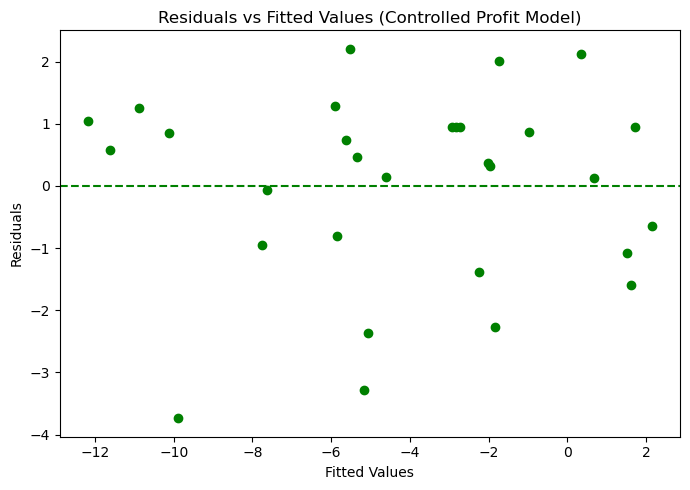

In [344]:
## visual for controlled profit model

# create fitted/predicted values variable
fitted_ctrl = controlled_profit_model.fittedvalues

# create residuals variable
resid_ctrl = controlled_profit_model.resid

# plot values on a scatterplot
plt.figure(figsize = (7,5))
plt.scatter(fitted_ctrl, resid_ctrl, color = "green")

# add 0 line
plt.axhline(y = 0, linestyle = '--', color = "green")

# add plot details
plt.title("Residuals vs Fitted Values (Controlled Profit Model)")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()

# export figure
figures_folder = base_folder / "figures"

figure3_path = figures_folder / "controlled_profit_model_residuals.png"

plt.savefig(figure3_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()

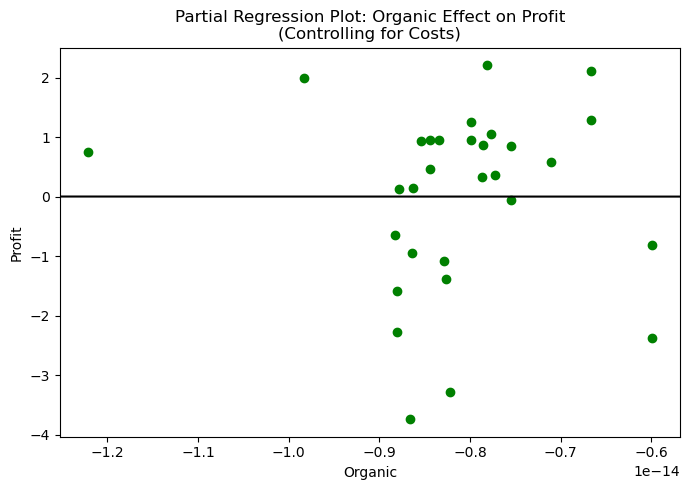

In [324]:
## visual
# plot relationship between profit and organic (partial regression)
fig = plt.figure(figsize = (7,5))

plot_partregress(endog = 'profit_real',
                 exog_i = 'organic_bin',
                 exog_others = ['organic_bin + feed_costs_real + bedding_litter_costs_real + marketing_costs_real + service_costs_real + utility_costs_real + repair_costs_real + overhead_real'],
                 data = milk_df_inflation,
                 obs_labels = False, 
                 ax = fig.add_subplot(111),
                 color = "green")

# add plot details
plt.title("Partial Regression Plot: Organic Effect on Profit\n(Controlling for Costs)")
plt.xlabel("Organic")
plt.ylabel("Profit")
plt.tight_layout()

# export figure
figures_folder = base_folder / "figures"

figure4_path = figures_folder / "partial_regression_plot.png"

plt.savefig(figure4_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()

In [262]:
## new equation idea
# does being organic predict sales
sales_model = smf.ols(
    """milk_sold_real ~ 
    organic_bin + feed_costs_real + bedding_litter_costs_real + marketing_costs_real +
    service_costs_real + utility_costs_real + repair_costs_real + overhead_real""",
    data = milk_df_inflation).fit()

# return model
sales_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         milk_sold_real   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     33.46
Date:                Sat, 13 Dec 2025   Prob (F-statistic):           2.95e-10
Time:                        13:59:50   Log-Likelihood:                -56.100
No. Observations:                  30   AIC:                             130.2
Df Residuals:                      21   BIC:                             142.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     7.2656      2.874      2.528      0.020       1.289      13.242
organic_bin                   8.0109      2.093      3.827      0.001       3.658      12.364
feed_costs_real               0.6957      0.236      2.945      0.008       0.204       1.187
bedding_litter_costs_real    -6.7973      3.871     -1.756      0.094     -14.847       1.252
marketing_costs_real          1.4179      3.318      0.427      0.674      -5.483       8.319
service_costs_real            1.6013      2.095      0.764      0.453      -2.755       5.957
utility_costs_real            1.2863      2.849      0.451      0.656      -4.639       7.212
repair_costs_real             3.8063      1.350      2.820      0.010       0.999       6.613
overhead_real                -0.1912      0.209     -0.915      0.371      -0.626       0.244
==============================================================================
Omnibus:                        4.493   Durbin-Watson:                   1.934
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                3.835
Skew:                          -0.872   Prob(JB):                        0.147
Kurtosis:                       2.844   Cond. No.                         223.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [272]:
## create table of sales model for paper

# put model selected results into a dataframe
results3_table = pd.DataFrame({"coef": sales_model.params,
                               "std_err": sales_model.bse,
                               "t_value": sales_model.tvalues,
                               "p_value": sales_model.pvalues,
                               "lower_CI": sales_model.conf_int()[0],
                               "upper_CI": sales_model.conf_int()[1]})

# view the table
results3_table

# create path to folder
results_folder = base_folder / "results"

output_path = results_folder / "sales_model_results.xlsx"

results3_table.to_excel(output_path, index = True)

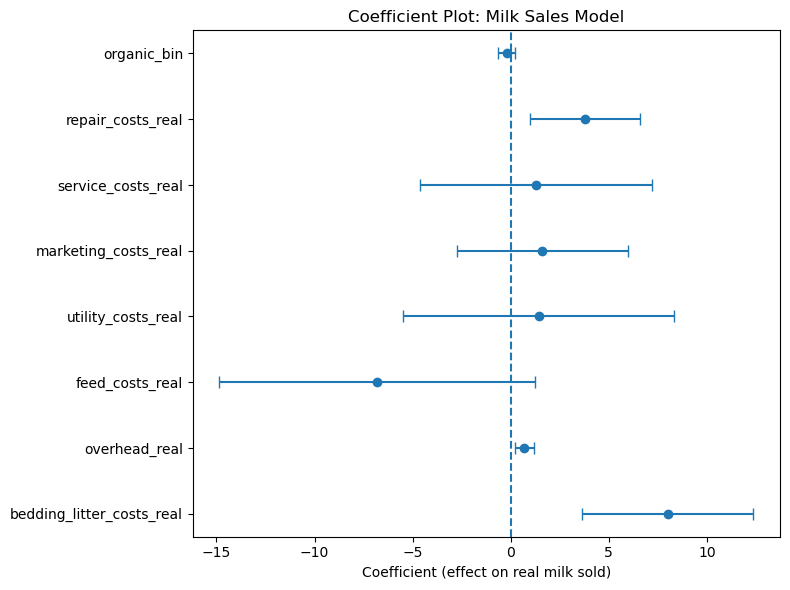

In [340]:
## visual for sales model
# coefficient table
parameters = sales_model.params
ci = sales_model.conf_int()
ci.columns = ["lower_CI", "upper_CI"]

coefficient_df = pd.DataFrame({"coef": parameters, 
                               "lower_CI": ci["lower_CI"], 
                               "upper_CI": ci["upper_CI"]})

# drop intercept
coefficient_df = coefficient_df.drop(index = "Intercept", errors = "ignore")

# create plot
plt.figure(figsize = (8, 6))

y_pos = np.arange(len(coefficient_df))

plt.errorbar(coefficient_df["coef"],y_pos, 
             xerr = [coefficient_df["coef"] - coefficient_df["lower_CI"],
                     coefficient_df["upper_CI"] - coefficient_df["coef"]],
             fmt = "o", capsize = 4)

# add 0 line
plt.axvline(0, linestyle = "--")

# add plot details
plt.yticks(y_pos, coef_df["var_name"])
plt.xlabel("Coefficient (effect on real milk sold)")
plt.title("Coefficient Plot: Milk Sales Model")
plt.tight_layout()

# export figure
figures_folder = base_folder / "figures"

figure5_path = figures_folder / "sales_model_coefficients.png"

plt.savefig(figure5_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()

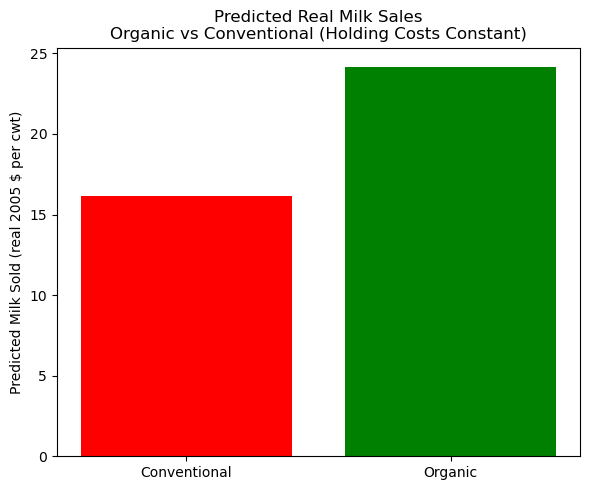

In [338]:
## visual for sales model
# identify predictor variables
predictor_variables = ["organic_bin", "feed_costs_real", "bedding_litter_costs_real", 
                       "marketing_costs_real", "service_costs_real",
                       "utility_costs_real", "repair_costs_real", "overhead_real"]

# get average costs
cost_means = milk_df_inflation[predictor_variables].mean()

# create prediction dataframe
prediction_df = pd.DataFrame({"organic_bin": [0, 1],})

# assigns average costs to organic and nonorganic farms
for var in predictor_variables:
    if var != "organic_bin":
        prediction_df[var] = cost_means[var]

# use regression model (sales_model) to get predicted milk sales
prediction_df["predicted_milk_sold_real"] = sales_model.predict(prediction_df)

# make labels and colors
prediction_df["Organic_label"] = prediction_df["organic_bin"].map({0: "Conventional", 1: "Organic"})
color_map = {"Conventional": "red", "Organic": "green"}
bar_colors = prediction_df["Organic_label"].map(color_map)

# plot of predicted values
plt.figure(figsize = (6, 5))
plt.bar(prediction_df["Organic_label"], prediction_df["predicted_milk_sold_real"],
        color = bar_colors)

# add plot details
plt.ylabel("Predicted Milk Sold (real 2005 $ per cwt)")
plt.title("Predicted Real Milk Sales\nOrganic vs Conventional (Holding Costs Constant)")
plt.tight_layout()

# export figure
figures_folder = base_folder / "figures"

figure6_path = figures_folder / "sales_model_predicted_organic_vs_conventional.png"

plt.savefig(figure6_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()

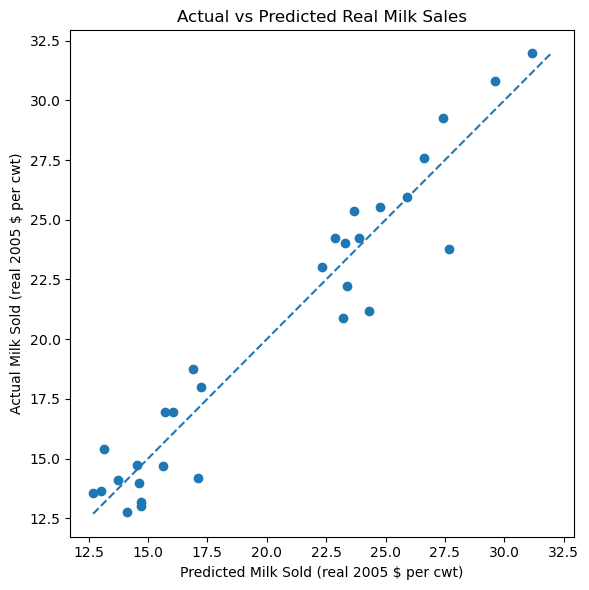

In [306]:
## visual for sales model

# create fitted/predicted values variable
milk_df_inflation["predicted_milk_sold_real"] = sales_model.fittedvalues

# create residuals variable
milk_df_inflation["residuals"] = sales_model.resid

# plot of predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(milk_df_inflation["predicted_milk_sold_real"], 
            milk_df_inflation["milk_sold_real"])

# identify min and mx values
min_value = min(milk_df_inflation["predicted_milk_sold_real"].min(),
              milk_df_inflation["milk_sold_real"].min())
max_value = max(milk_df_inflation["predicted_milk_sold_real"].max(),
              milk_df_inflation["milk_sold_real"].max())

# add 45 degree line
plt.plot([min_value, max_value], [min_value, max_value], linestyle = "--")

# add plot details
plt.xlabel("Predicted Milk Sold (real 2005 $ per cwt)")
plt.ylabel("Actual Milk Sold (real 2005 $ per cwt)")
plt.title("Actual vs Predicted Real Milk Sales")
plt.tight_layout()

# export figure
figures_folder = base_folder / "figures"

figure7_path = figures_folder / "sales_model_actual_vs_predicted.png"

plt.savefig(figure7_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()

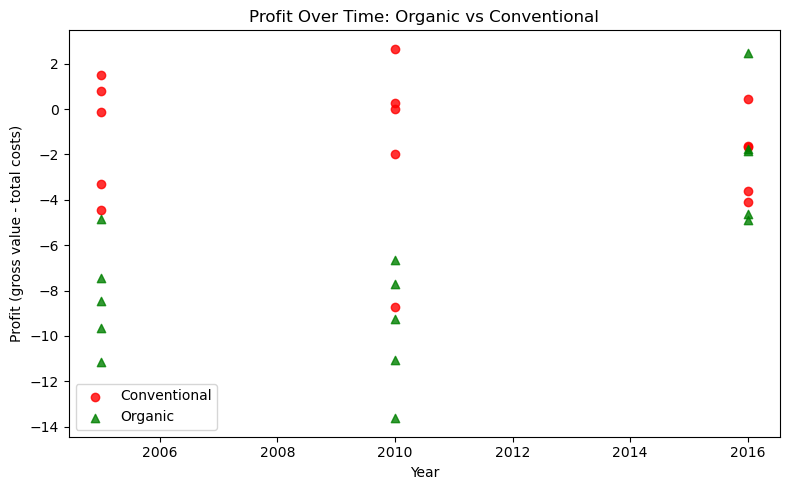

In [330]:
### data exploration
## explore profit trends

# split organic and conventional data
org = milk_df_inflation[milk_df_inflation["Organic"] == 1]
conv = milk_df_inflation[milk_df_inflation["Organic"] == 0]

# plot raw profits on scatterplot 
plt.figure(figsize = (8, 5))
plt.scatter(conv["Year"], conv["profit_real"], alpha = 0.8, label = "Conventional",
            marker = "o", color = "red")
plt.scatter(org["Year"], org["profit_real"], alpha = 0.8, label = "Organic",
            marker = "^", color = "green")

# add plot details
plt.xlabel("Year")
plt.ylabel("Profit (gross value - total costs)")
plt.title("Profit Over Time: Organic vs Conventional")
plt.legend()
plt.tight_layout()

# export figure
figures_folder = base_folder / "figures"

figure5_path = figures_folder / "profit_over_time.png"

plt.savefig(figure5_path, dpi = 300, bbox_inches = "tight")

# display visual
plt.show()